In [13]:
import numpy as np
import gym
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import time
import matplotlib.pyplot as plt

In [28]:
env = gym.make('LunarLander-v2')
#Setting up the environment
#env = gym.make('CartPole-v1')
seed_val = 456
env.seed(seed_val)
np.random.seed(seed_val)

In [29]:
class Network(nn.Module):
    
    def __init__(self, state_num , action_num, hidden_layer):
        
        super(Network, self).__init__()
        self.input_layer = nn.Linear(state_num, hidden_layer)
        self.h1_layer = nn.Linear(hidden_layer, hidden_layer)
        self.h2_layer = nn.Linear(hidden_layer, hidden_layer)
        self.output_layer = nn.Linear(hidden_layer, action_num)
        

    def forward(self, state):
        
        xh = F.relu(self.input_layer(state))
        hh1 = F.relu(self.h1_layer(xh))
        hh2 = F.tanh(self.h2_layer(hh1))
        state_action_values = self.output_layer(hh2)
        
        return state_action_values

In [30]:
class Q_Network(nn.Module):
    def __init__(self, state_dim , action_dim):
        super(Q_Network, self).__init__()
        self.x_layer = nn.Linear(state_dim, 150)
        self.h_layer = nn.Linear(150, 120)
        self.y_layer = nn.Linear(120, action_dim)
        print(self.x_layer)

    def forward(self, state):
        xh = F.relu(self.x_layer(state))
        hh = F.relu(self.h_layer(xh))
        state_action_values = self.y_layer(hh)
        return state_action_values

In [46]:
class DQNAgent(object):
    def __init__(self, state_dim, action_dim):
        self.qnet = Q_Network(state_dim, action_dim)
        self.qnet_optim = torch.optim.Adam(self.qnet.parameters(), lr=0.001)
        self.discount_factor = 0.99
        self.beta = 0.1
        self.MSELoss_function = nn.MSELoss()
        self.replay_buffer = ReplayBuffer()
        pass
    
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon:
                return env.action_space.sample()  # choose random action
        else:
                network_output_to_numpy = self.qnet(state).data.numpy()
                return np.argmax(network_output_to_numpy)  # choose greedy action

    def update_Q_Network(self, state, next_state, action, reward, terminals):
        
        qsa = torch.gather(self.qnet(state), dim=1, index=action.long())
        qsa_next_action = self.qnet(next_state)
        qsa_next_action,_ = torch.max(qsa_next_action, dim=1, keepdim=True)
        not_terminals = 1 - terminals
        qsa_next_target = reward + not_terminals * self.discount_factor * qsa_next_action
        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
        
    
    def update_Sarsa_Network(self, state, next_state, action, next_action, reward, terminals):

        qsa = torch.gather(self.qnet(state), dim=1, index=action.long())

        qsa_next_action = torch.gather(self.qnet(next_state), dim=1, index=next_action.long())

        not_terminals = 1 - terminals

        qsa_next_target = reward + not_terminals * (self.discount_factor * qsa_next_action)

        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
    
    # FIXME
    def update_Bpessimistic_Network(self, state, next_state, action, reward, terminals):
        qsa = torch.gather(self.qnet(state), dim=1, index=action.long())
        
        qsa_next_action = self.qnet(next_state)
        qsa_best_next_action = torch.max(qsa_next_action, dim=1, keepdim=True)
        qsa_worst_next_action = torch.min(qsa_next_action, dim=1, keepdim=True)
        
        print(type(qsa_best_next_action))
        print(qsa_best_next_action)
        print(qsa_best_next_action.values)
        
        not_terminals = 1 - terminals
        qsa_next_target = reward + not_terminals * self.discount_factor * ((1-self.beta) * qsa_best_next_action + self.beta * qsa_worst_next_action)
        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
        
    def update(self, update_rate):
        for i in range(update_rate):
            states, next_states, actions, rewards, terminals = self.replay_buffer.sample_minibatch(64)
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals)
            self.update_Q_Network(states, next_states, actions, rewards, terminals)
            
    def update_s(self, update_rate):
        for i in range(update_rate):
            states, next_states, actions, next_actions, rewards, terminals = self.replay_buffer.sample_minibatch_sarsa(64)
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)
            next_actions = torch.Tensor(next_actions)
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals)
            self.update_Sarsa_Network(states, next_states, actions, next_actions, rewards, terminals)
    
    def update_b(self, update_rate):
        for i in range(update_rate):
            states, next_states, actions, rewards, terminals = self.replay_buffer.sample_minibatch(64)
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals)
            self.update_Bpessimistic_Network(states, next_states, actions, rewards, terminals)
            
    def best_move(self, state):
        
        return np.argmax(self.qnet(state).data.numpy())

In [32]:
class ReplayBuffer(object):
    def __init__(self):
        self.buffer = []
        self.buffer_s = []
        
    def add_to_buffer(self, data):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer.append(data)
        
    def add_to_buffer_sarsa(self, data):
        #data must be of the form (state,next_state,action,n_action,reward,terminal)
        self.buffer_s.append(data)

    def sample_minibatch(self,minibatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        for i in range(minibatch_length):
            random_int = np.random.randint(0, len(self.buffer)-1) 
            transition = self.buffer[random_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            rewards.append(transition[3])
            terminals.append(transition[4])
        return torch.Tensor(states), torch.Tensor(next_states), torch.Tensor(actions), torch.Tensor(rewards), torch.Tensor(terminals)

    def sample_minibatch_sarsa(self,minibatch_length):
        states = []
        next_states = []
        actions = []
        next_actions = []
        rewards = []
        terminals = []
        for i in range(minibatch_length):
            random_int = np.random.randint(0, len(self.buffer_s)-1) 
            transition = self.buffer_s[random_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            next_actions.append(transition[3])
            rewards.append(transition[4])
            terminals.append(transition[5])
        return torch.Tensor(states), torch.Tensor(next_states), torch.Tensor(actions), torch.Tensor(next_actions), torch.Tensor(rewards), torch.Tensor(terminals)

In [33]:
def m_a(values, window=50):
    weight = np.repeat(1.0, window)/window
    smas = np.convolve(values,weight,'valid')
    return smas

In [34]:
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]

In [47]:
agent = DQNAgent(state_dim, action_dim)
number_of_episodes = 600
max_time_steps = 2000
reward_list = []
epsilon = 1
finals = []


for episode in range(number_of_episodes):
    reward_sum = 0
    state = env.reset()

    for _ in range(max_time_steps):
        action = agent.epsilon_greedy_action(torch.from_numpy(state).float() , epsilon)
        next_state, reward, terminal, _ = env.step(action)
        
        reward_sum += reward
        agent.replay_buffer.add_to_buffer((state,next_state,[action],[reward],[terminal]))
        state = next_state
        if terminal:
            clear_output(wait=True)
            print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)
            reward_list.append(reward_sum)
            finals.append(reward)
            break
            
    agent.update_b(128)
    
    if epsilon > 0.2:
        epsilon *= 0.995 #Epsilon decay
    
    if epsilon <= 0.2:
        epsilon = 0.2

episode: 0 sum_of_rewards_for_episode: -302.0596005323375
<class 'torch.return_types.max'>
torch.return_types.max(
values=tensor([[0.1023],
        [0.1261],
        [0.1292],
        [0.1349],
        [0.1260],
        [0.1342],
        [0.1329],
        [0.1375],
        [0.1272],
        [0.1045],
        [0.1327],
        [0.1249],
        [0.1027],
        [0.1270],
        [0.1119],
        [0.1027],
        [0.1150],
        [0.1237],
        [0.1514],
        [0.1039],
        [0.1340],
        [0.1069],
        [0.1027],
        [0.1032],
        [0.1325],
        [0.1231],
        [0.1023],
        [0.1045],
        [0.1150],
        [0.1237],
        [0.1260],
        [0.1239],
        [0.1231],
        [0.1032],
        [0.1372],
        [0.1191],
        [0.1181],
        [0.1300],
        [0.1154],
        [0.1249],
        [0.1061],
        [0.1035],
        [0.1313],
        [0.1096],
        [0.1041],
        [0.1366],
        [0.1044],
        [0.1154],
        [0.104

TypeError: can't multiply sequence by non-int of type 'float'

In [11]:
smas_ = m_a(reward_list)
# np.where(smas_> 100)

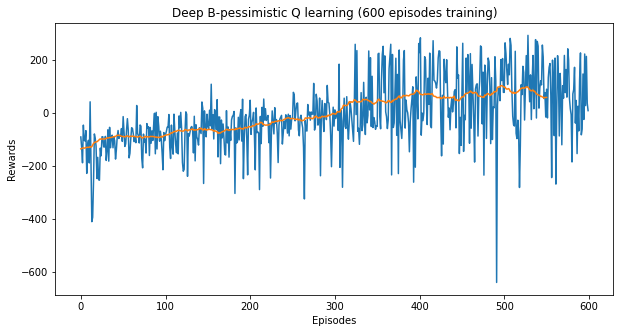

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(reward_list)
ax.plot(smas_)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
ax.set_title('Deep B-pessimistic Q learning (600 episodes training)')
plt.savefig('DQN600epma', transparent=True)

In [ ]:
state = env.reset()

while True:
    
    env.render()
    action = agent.best_move(torch.from_numpy(state).float())
    
    next_state, _, terminal, _ = env.step(action)
    
    state = next_state
    
    if terminal:
        break
    
env.close()